<a href="https://colab.research.google.com/github/project-ida/two-state-quantum-systems/blob/master/05-excitation-transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <a href="https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/05-excitation-transfer.ipynb" target="_parent"><img src="https://nbviewer.jupyter.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>

# 5 - Excitation transfer

[Last time](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/04-spin-boson-model.ipynb), we explored the spin boson model and found the surprising physics of down conversion. This is where many bosons are emitted/absorbed (rather than a single boson) when a two state system (TSS) makes a transition. This is not what's usually taught to be possible in introductory quantum mechanics courses.

Today, we are going to extend the spin boson model by adding another TSS into the mix. What new lessons does mother nature have for us... the clue is in the name of the tutorial 😉 .

This tutorial is split up into the following sections:
1. [Recap](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/05-excitation-transfer.ipynb#5.1---Recap)
2. [Adding more two state systems](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/05-excitation-transfer.ipynb#5.2---Adding-more-two-state-systems)
3. [Structure of the Hamiltonian](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/05-excitation-transfer.ipynb#5.3----Structure-of-the-Hamiltonian)
4. [Parity](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/05-excitation-transfer.ipynb#5.4---Parity)
5. [Energy level landscape](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/05-excitation-transfer.ipynb#5.5---Energy-level-landscape)
6. [Crossings and anti-crossings](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/05-excitation-transfer.ipynb#5.6---Crossings-and-anti-crossings)
7. [Excitation transfer](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/05-excitation-transfer.ipynb#5.7---Excitation-transfer)

In [1]:
# Libraries and helper functions

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image

import numpy as np
from itertools import product
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from qutip import *
from qutip.piqs import *

from scipy.optimize import minimize_scalar

# The helper file below brings functions created in previous tutorials and adds an extra one
# make_df_for_energy_scan - we made this in tutorial 4
# make_braket_labels - we made this in tutorial 4
# simulate - we made this in tutorial 4
# plot_prob - made from code used for plotting in tutorial 4
# prettify_states - nice way to display many QuTiP states for side by side comparison
# 
from libs.helper_05_tutorial import *

## 5.1 - Recap

Let's remind ourselves of the Hamiltonian that we used in the last tutorial ([Tutorial 4](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/04-spin-boson-model.ipynb))

$$H =  \frac{\Delta E}{2} \sigma_z + \hbar\omega\left(a^{\dagger}a +\frac{1}{2}\right) + U\left( a^{\dagger} + a \right)\sigma_x$$

where we recognise $\Delta E$ as the transition energy of the TSS, $\hbar\omega$ the energy of a single boson and $U$ as the strength of the interaction between the TSS and the boson field.

We described the states of the system above using the notation $|n,\pm \rangle$.

To help us move towards systems with many TSS, let's enumerate the states for the Hamiltonian above using an example where we only allow `max_bosons=4`.

In [2]:
max_bosons=4

We [previously](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/04-spin-boson-model.ipynb#4.3---Structure-of-the-Hamiltonian) enumerated the states by doing:

In [3]:
# map from QuTiP number states to |n,±> states
possible_ns = range(0, max_bosons+1)
possible_ms = ["+","-"]
nm_list = [(n,m) for (n,m) in product(possible_ns, possible_ms)]

In [4]:
nm_list

[(0, '+'),
 (0, '-'),
 (1, '+'),
 (1, '-'),
 (2, '+'),
 (2, '-'),
 (3, '+'),
 (3, '-'),
 (4, '+'),
 (4, '-')]

and we represented these states in QuTiP using the tensor product (see [Tutorial 3](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/03-a-two-state-system-in-a-quantised-field.ipynb#3.5---Describing-coupled-systems-in-QuTiP)). For example, the state $|1, +\rangle$ can be represented in QuTiP by:

In [5]:
#         bosons,                TSS, 
tensor(basis(max_bosons+1,1), basis(2,0))

Quantum object: dims = [[5, 2], [1, 1]], shape = (10, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

We also used tensor products for the operators that make up the Hamiltonian (see [Tutorial 4](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/04-spin-boson-model.ipynb#4.2---Stationary-states)). Specifically:
- `two_state` = $\frac{1}{2}\sigma_z$
- `bosons` = $a^{\dagger}a +\frac{1}{2}$
- `interaction`= $\left( a^{\dagger} + a \right)\sigma_x$

In [6]:
a  = tensor(destroy(max_bosons+1), qeye(2))     # tensorised boson destruction operator
sx = tensor(qeye(max_bosons+1), sigmax())       # tensorised 𝜎𝑥 operator
sz = tensor(qeye(max_bosons+1),sigmaz())        # tensorised 𝜎𝑧 operator

two_state     =  1/2*sz                         # two state system energy operator   𝜎𝑧/2
bosons       =  (a.dag()*a+0.5)                 # boson energy operator              𝑎†𝑎+1/2
number        = a.dag()*a                       # boson number operator              𝑎†𝑎
interaction  = (a.dag() + a) * sx               # interaction energy operator        (𝑎†+𝑎)𝜎𝑥  

Now, we have recalled what we did before, we are in a good place to extend these ideas to include an extra TSS.

## 5.2 - Adding more two state systems

For this tutorial we will consider 2 identical TSS (`TSS_1` and `TSS_2`) whose interaction with the boson field is also identical. In this case, we can extend the single TSS Hamiltonian in the following way:

$$H =  \frac{\Delta E}{2} (\sigma_{z1} + \sigma_{z2}) + \hbar\omega\left(a^{\dagger}a +\frac{1}{2}\right) + U\left( a^{\dagger} + a \right)(\sigma_{x1} + \sigma_{x2})$$

where subscripts 1 and 2 refer to `TSS_1` and `TSS_2` respectively.

We will be referring to this Hamiltonian a lot in figure titles, so we'll create a variable for the corresponding Latex so that it's easy to refer to later.

In [7]:
H_latex = "$H = \Delta E /2 (\sigma_{z1} + \sigma_{z2}) + \hbar\omega(a^{{\dagger}}a +1/2) + U( a^{{\dagger}} + a )(\sigma_{x1} +\sigma_{x2} )$ "

How shall we describe the states of the system above? We can add another $\pm$ "index" to the state notation like this:

$|n,\pm, \pm \rangle$

Let's enumerate the states for the Hamiltonian above (again using `max_bosons=4`) by extending the ideas that we used for the single TSS - we just need to add an extra argument to the `product` function.

In [8]:
# map from QuTiP number states to |n,±, ±> states
possible_ns = range(0, max_bosons+1)
possible_ms = ["+","-"]
nmm_list = [(n,m1,m2) for (n,m1,m2) in product(possible_ns, possible_ms, possible_ms)]

In [9]:
nmm_list

[(0, '+', '+'),
 (0, '+', '-'),
 (0, '-', '+'),
 (0, '-', '-'),
 (1, '+', '+'),
 (1, '+', '-'),
 (1, '-', '+'),
 (1, '-', '-'),
 (2, '+', '+'),
 (2, '+', '-'),
 (2, '-', '+'),
 (2, '-', '-'),
 (3, '+', '+'),
 (3, '+', '-'),
 (3, '-', '+'),
 (3, '-', '-'),
 (4, '+', '+'),
 (4, '+', '-'),
 (4, '-', '+'),
 (4, '-', '-')]

The tensor products can also be extended by adding an extra argument. For example, the state  $|1,+, + \rangle$ is represented by:

In [10]:
#           bosons,             TSS_1,        TSS_2
tensor(basis(max_bosons+1,1), basis(2,0), basis(2,0))

Quantum object: dims = [[5, 2, 2], [1, 1, 1]], shape = (20, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

Now we do the same for the operators:

- `two_state_1` = $\frac{1}{2}\sigma_{z1}$
- `two_state_2` = $\frac{1}{2}\sigma_{z2}$
- `bosons` = $a^{\dagger}a +\frac{1}{2}$
- `interaction_1`= $\left( a^{\dagger} + a \right)\sigma_{x1}$
- `interaction_2`= $\left( a^{\dagger} + a \right)\sigma_{x2}$

In [11]:
a     = tensor(destroy(max_bosons+1), qeye(2), qeye(2))     # tensorised boson destruction operator
sx1   = tensor(qeye(max_bosons+1), sigmax(), qeye(2))       # tensorised 𝜎𝑥1 operator 
sx2   = tensor(qeye(max_bosons+1), qeye(2), sigmax())       # tensorised 𝜎𝑥2 operator 
sz1   = tensor(qeye(max_bosons+1), sigmaz(), qeye(2))       # tensorised 𝜎z1 operator 
sz2   = tensor(qeye(max_bosons+1), qeye(2), sigmaz())       # tensorised 𝜎z2 operator 

two_state_1     =  1/2*sz1                             # two_state_1 energy operator        𝜎𝑧1/2
two_state_2     =  1/2*sz2                             # two_state_2 energy operator        𝜎𝑧2/2
bosons          = (a.dag()*a+0.5)                      # boson energy operator              𝑎†𝑎+1/2
number          = a.dag()*a                            # boson number operator              𝑎†𝑎
interaction_1   = (a.dag() + a) * sx1                  # interaction_1 energy operator      (𝑎†+𝑎)𝜎𝑥1  
interaction_2   = (a.dag() + a) * sx2                  # interaction_2 energy operator      (𝑎†+𝑎)𝜎𝑥2 

## 5.3  - Structure of the Hamiltonian

In [tutorial 4](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/04-spin-boson-model.ipynb#4.3---Structure-of-the-Hamiltonian), we learnt a lot from looking at the Hinton diagram of the Hamiltonian. What will we learn this time?

We'll use an example Hamiltonian with $\Delta E = \omega = U = 1$ for this visual exploration.

In [12]:
H = 1*two_state_1 + 1*two_state_2 + 1*bosons + 1*interaction_1 + 1*interaction_2

Let's not forget to make the pretty bra-ket labels for plotting. We are making use of the `make_braket_labels` function that we created last time and have imported from a helper file at the top of the notebook.

In [13]:
bra_labels, ket_labels = make_braket_labels(nmm_list)

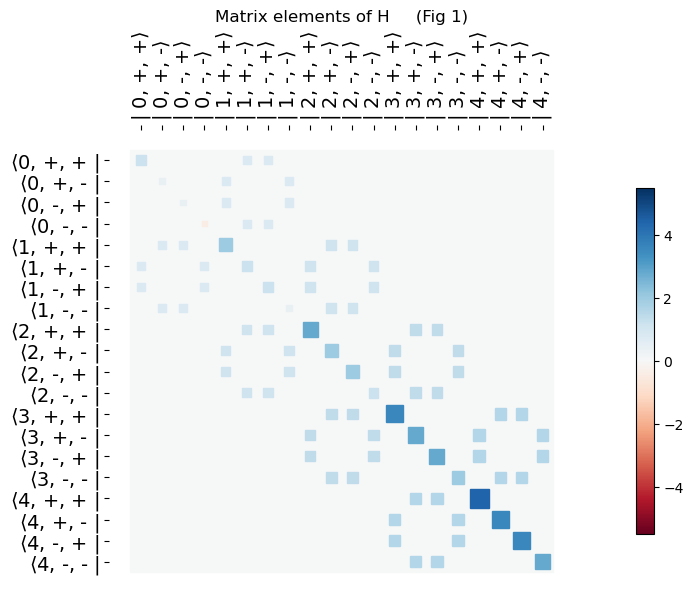

In [14]:
f, ax = hinton(H, xlabels=ket_labels, ylabels=bra_labels)
ax.tick_params(axis='x',labelrotation=90)
ax.set_title("Matrix elements of H     (Fig 1)");

First, a short reminder from [last time](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/04-spin-boson-model.ipynb#4.3---Structure-of-the-Hamiltonian). Each off-diagonal coloured square represents an interaction between 2 states of the system (aka a non-zero matrix element of the Hamiltonian). If there is no coloured square then the particular 2 states in question are not connected, i.e. they cannot transform into one another.

Looking now in detail at Fig 1. As we might have guessed, the Hinton diagram in is more complicated than for a single TSS (see [Fig 4 of tutorial 4](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/04-spin-boson-model.ipynb#4.3---Structure-of-the-Hamiltonian)). Each state is connected to twice as many states as previously. For example, $|0,+, + \rangle$ (top left corner) is coupled to the following 2 states:
- $|1,+, - \rangle$
- $|1,-, + \rangle$

Just as in the last tutorial, we can draw indirect paths connecting different states to get a feeling for what dynamics might be possible. There are many more paths compared to a single TSS - we'll just look at a few.

For example:

                Matrix elements of H     (Fig 2)


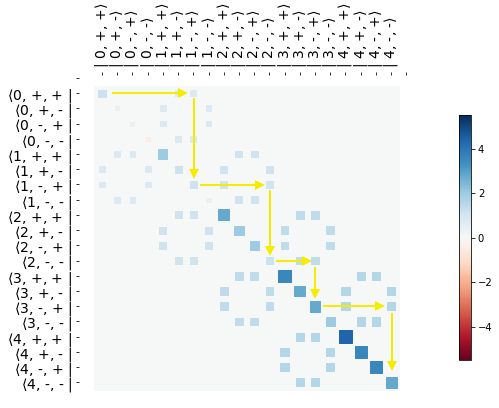

In [15]:
print("                Matrix elements of H     (Fig 2)")
Image(filename='./img/05-hinton-01.png') 

In Fig 2, we imagine that we start in the state $|0,+, + \rangle $. Similar to the previous tutorial, following horizontal and vertical arrows reveals indirect connections between the starting state and others with different numbers of bosons:

$|0,+, + \rangle \rightarrow |1,-, + \rangle \rightarrow |2,-, - \rangle \rightarrow |3,-, + \rangle \rightarrow |4,-, - \rangle$

What can we learn from this pathway?

We can expect that the indirect path from $|0,+, + \rangle \rightarrow |2,-, - \rangle$ could be physically realised by each TSS emitting a single boson whose energy matches the TSS transition energy, i.e. $\Delta E = \omega$, - in this way energy is conserved. We've seen similar physics for single TSS - nothing new here.

We can also expect that the indirect path from $|0,+, + \rangle \rightarrow |4,-, - \rangle$ could be physically realised by each TSS emitting a 2 bosons whose energy is half the TSS transition energy, i.e. $\Delta E = 2\omega$, - in this way energy is also conserved. This is another example of down conversion that we found last time - again nothing new here.

We can also draw quite different pathways like the one below.

                Matrix elements of H     (Fig 3)


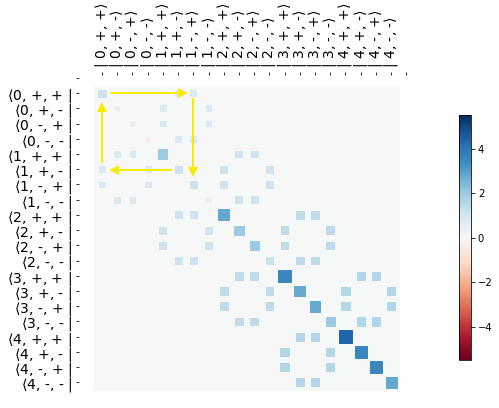

In [16]:
print("                Matrix elements of H     (Fig 3)")
Image(filename='./img/05-hinton-02.png') 

In Fig 3 above, we imagine starting in the state $|1,+, - \rangle $ and then through connections to states with a different number of bosons we end up back with 1 boson but the "+" and "-" switch places, i.e.

$|1,+, - \rangle \rightarrow |0,+, + \rangle \rightarrow |1,-, + \rangle$

We could describe such an indirect path from $|1,+, - \rangle \rightarrow |1,-, + \rangle$ as **excitation transfer** because the "excitation" (i.e. the +) moves from one TSS to another - this is something that we've not encountered before and we'd like to explore this in more detail through simulation.

Before we are able to simulate, we need to also extend the ideas of parity that we [introduced last time](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/04-spin-boson-model.ipynb#4.4---Parity) and bring everything together in a convenient function that we can use again and again.


## 5.4 - Parity
In [tutorial 4](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/04-spin-boson-model.ipynb#4.4---Parity), we discovered that two distinct parity universes co-existed inside the Hamiltonian and that each universe could be be treated in isolation.

We calculated parity using the operator $\sigma_z e^{i\pi n}$ where $n$ is the boson number operator.

We can guess at how to extend this idea to 2 TSS - let's try  $\sigma_{z1}\sigma_{z2} e^{i\pi n}$.

In [17]:
P = sz1*sz2*(1j*np.pi*number).expm()              # parity operator

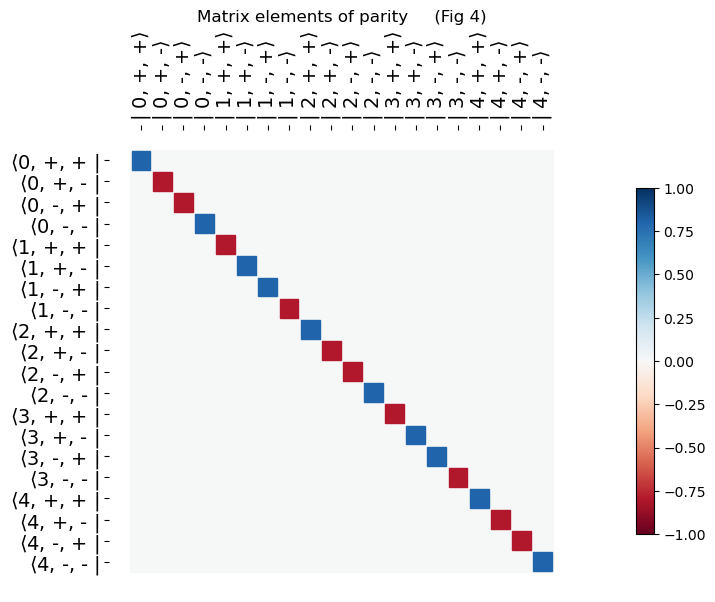

In [18]:
f, ax = hinton(P, xlabels=ket_labels, ylabels=bra_labels)
ax.tick_params(axis='x',labelrotation=90)
ax.set_title("Matrix elements of parity     (Fig 4)");

Fig 4 shows us that our guess at parity creates a binary $\pm 1$ similar to what we saw in the last tutorial - so far so good. The most important question is, does our guess at parity commute with the Hamiltonian - if it does then it is conserved and we therefore have a well defined parity operator that we can use to split the universes.

In [19]:
commutator(H,P).full

<bound method Qobj.full of Quantum object: dims = [[5, 2, 2], [5, 2, 2]], shape = (20, 20), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

We have zero commutator - this shows that partiy is indeed conserved.

We are now ready to put this all together in much the same way we did in the last tutorial, i.e. create a function that can extract the even parity universe (+1) or the odd parity universe (-1).

In [20]:
def make_operators(max_bosons, parity=0):
    
    a     = tensor(destroy(max_bosons+1), qeye(2), qeye(2))     # tensorised boson destruction operator
    sx1   = tensor(qeye(max_bosons+1), sigmax(), qeye(2))       # tensorised 𝜎𝑥1 operator 
    sx2   = tensor(qeye(max_bosons+1), qeye(2), sigmax())       # tensorised 𝜎𝑥2 operator 
    sz1   = tensor(qeye(max_bosons+1), sigmaz(), qeye(2))       # tensorised 𝜎z1 operator 
    sz2   = tensor(qeye(max_bosons+1), qeye(2), sigmaz())       # tensorised 𝜎z2 operator 

    two_state_1     =  1/2*sz1                                  # two state system energy operator   𝜎𝑧1/2
    two_state_2     =  1/2*sz2                                  # two state system energy operator   𝜎𝑧2/2
    bosons          = (a.dag()*a+0.5)                           # boson energy operator              𝑎†𝑎+1/2
    number          = a.dag()*a                                 # boson number operator              𝑎†𝑎
    interaction_1   = (a.dag() + a) * sx1                       # interaction energy operator       (𝑎†+𝑎)𝜎𝑥1  
    interaction_2   = (a.dag() + a) * sx2                       # interaction energy operator       (𝑎†+𝑎)𝜎𝑥2  
    
    P = sz1*sz2*(1j*np.pi*number).expm()                        # parity operator 
    
    # map from QuTiP number states to |n,±, ±> states
    possible_ns = range(0, max_bosons+1)
    possible_ms = ["+","-"]
    nmm_list = [(n,m1,m2) for (n,m1,m2) in product(possible_ns, possible_ms, possible_ms)]
    
    # only do parity extraction if a valid parity is being used
    if (parity==1) | (parity==-1):
        p           = np.where(P.diag()==parity)[0]
        
        two_state_1     = two_state_1.extract_states(p)
        two_state_2     = two_state_2.extract_states(p)
        bosons          = bosons.extract_states(p)
        number          = number.extract_states(p)
        interaction_1   = interaction_1.extract_states(p)
        interaction_2   = interaction_2.extract_states(p)
        nmm_list        = [nmm_list[i] for i in p]
    
    
    return two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nmm_list

So, we've got the parity universes under control and we've also got an idea of what dynamics might be possible from exploring the Hinton diagram. Let's now see if we can connect these dynamics with features in the energy level diagrams just as we did in the last tutorial. This will put us in the best place to be able to interpret the simulations we will make.

We start without any coupling between the TSS and the field, i.e. $U=0$ to get a sense of the landscape.

### 5.5 - Energy level landscape

We will work with $\omega = 1$ throughout the rest of the tutorial and we will also allow up to 6 bosons in our simulations, i.e. `max_bosons=6`.

Let's take a look at the energy levels for odd and even parity universes when there is no couping between the TSS and the boson field i.e. $U=0$.

Note, we will make use of the function `make_df_for_energy_scan` that we created in the last tutorial and is imported from the helper file at the top of the notebook.

In [21]:
# ODD PARITY

# make the operators
two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nmm_list = make_operators(
    max_bosons=6, parity=-1)

# prepare data structure for the energy level scan
df_odd = make_df_for_energy_scan("$\Delta E$", -4, 4, 201, two_state_1.shape[0])

# fill the data structure with eigenvalues of the Hamiltonian i.e. the energy levels
for i, row in df_odd.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + 1*bosons 
    evals, ekets = H.eigenstates()
    df_odd.iloc[i,1:] = evals 

In [22]:
# EVEN PARITY

# make the operators
two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nmm_list = make_operators(
    max_bosons=6, parity=1)

# prepare data structure for the energy level scan
df_even = make_df_for_energy_scan("$\Delta E$", -4, 4, 201, two_state_1.shape[0])

# fill the data structure with eigenvalues of the Hamiltonian i.e. the energy levels
for i, row in df_even.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + 1*bosons 
    evals, ekets = H.eigenstates()
    df_even.iloc[i,1:] = evals 

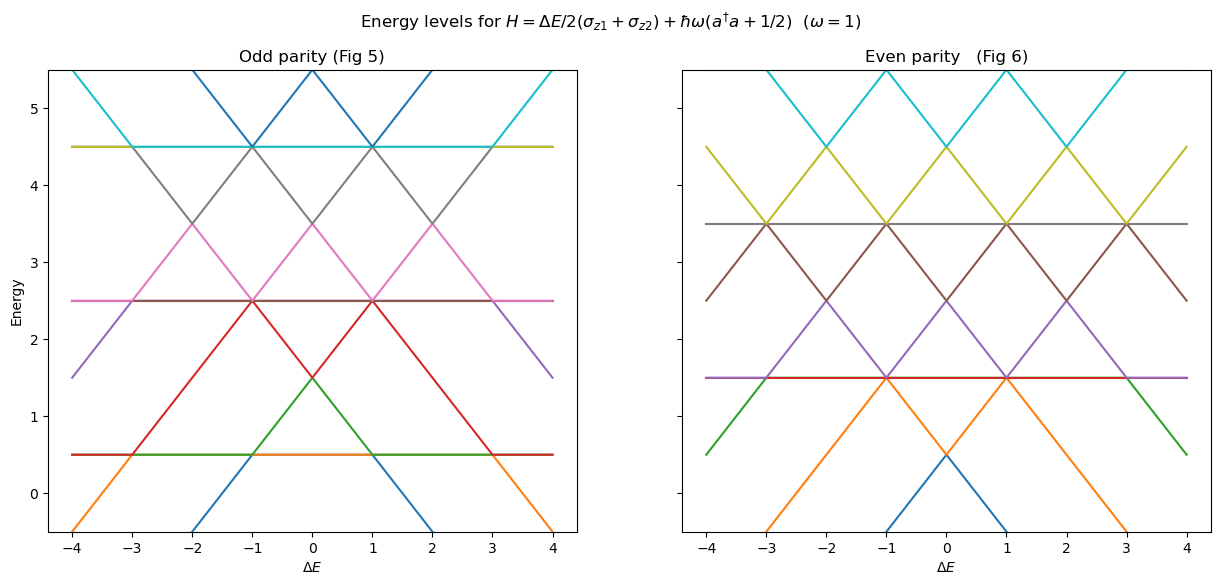

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6), sharey=True)

fig.suptitle("Energy levels for $H = \Delta E /2 (\sigma_{z1} + \sigma_{z2}) + \hbar\omega(a^{{\dagger}}a +1/2) $  ($\omega=1$)")


df_odd.plot(x="$\Delta E$",ylim=[-0.5,5.5],legend=False, 
        title="Odd parity (Fig 5)",  ax=axes[0]);

df_even.plot(x="$\Delta E$",ylim=[-0.5,5.5],legend=False, 
        title="Even parity   (Fig 6)",  ax=axes[1]);

axes[0].set_ylabel("Energy");



What can we say about the energy levels in Figs 5 and 6?

Compared to [Fig 1 of tutorial 4](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/04-spin-boson-model.ipynb#4.2.1---Spin-boson-landscape-$U=0$), we have some similarities and some differences:
- Similarity - levels that trend up and down with changing $\Delta E$. These correspond to states like $|n,+,+\rangle$ and $|n,-,-\rangle$. For example, in Fig 6 for small positive $\Delta E$ (referring to blue squares in Fig 4 for even parity states) we have:
  - $|0,-,-\rangle$ - blue
  - $|0,+,+\rangle$ - orange 
  - $|2,-,-\rangle$ - purple  
  - $|2,+,+\rangle$ - brown 
  - $|4,-,-\rangle$ - yellow 
  - $|4,+,+\rangle$ - light-blue 
- Difference - horizontal levels. These correspond to combinations of $|n,+,-\rangle$ and $|n,-,+\rangle$ which give is no overall "excitation" i.e. equal amounts of + and -. This kind of combination of basis states is often referred to as an [entangled state](https://en.wikipedia.org/wiki/Quantum_entanglement#Pure_states). The subject of quantum entanglement deserves at least a whole tutorial, so we'll come back to it another time.

Thinking more carefully about these unfamiliar horizontal levels, there are 2 ways we can combine $|n,+,-\rangle$ and $|n,-,+\rangle$ together:
- $|n,+,-\rangle + |n,-,+\rangle$ 
- $|n,+,-\rangle  - |n,-,+\rangle$ 

These combinations are reminiscent of the "in phase" and "out of phase" states that we described [back in tutorial 1](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/01-an-isolated-two-state-system.ipynb#1.2-Coupling-between-two-states-of-the-same-energy).  Because there are two combinations, we can expect that each horizontal line in Fig 6 is in fact 2 horizontal lines on top of each other, i.e:

 - $|1,+,-\rangle \pm |1,-,+\rangle $ - the lowest horizontal lines with energy = 1.5
 - $|3,+,-\rangle \pm |3,-,+\rangle $ - the highest horizontal lines with energy = 3.5

What else can we say about Fig 6?

When looking at where the levels cross, there appear to be two different situations:
- 2 levels come together - we've seen this before and we expect these to form anti-crossings when we switch the coupling on (i.e. $U\neq 0$)
- 4 levels come together - we've not encountered this before so we need to explore it further

From now on we'll continue our exploration using only even parity, i.e Fig 6. 

Let's switch on the coupling and see if there are any surprises.

## 5.6 - Crossings and anti-crossings

We'll create a relatively strong coupling to start with i.e. $U=0.1$. This way, we can easily spot any changes in the energy level diagram compard to Fig 6.

In [24]:
# We re-use operators that made Fig 6 (these had even parity)
for i, row in df_even.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + 1*bosons + 0.1*interaction_1 + 0.1*interaction_2
    evals, ekets = H.eigenstates()
    df_even.iloc[i,1:] = evals 

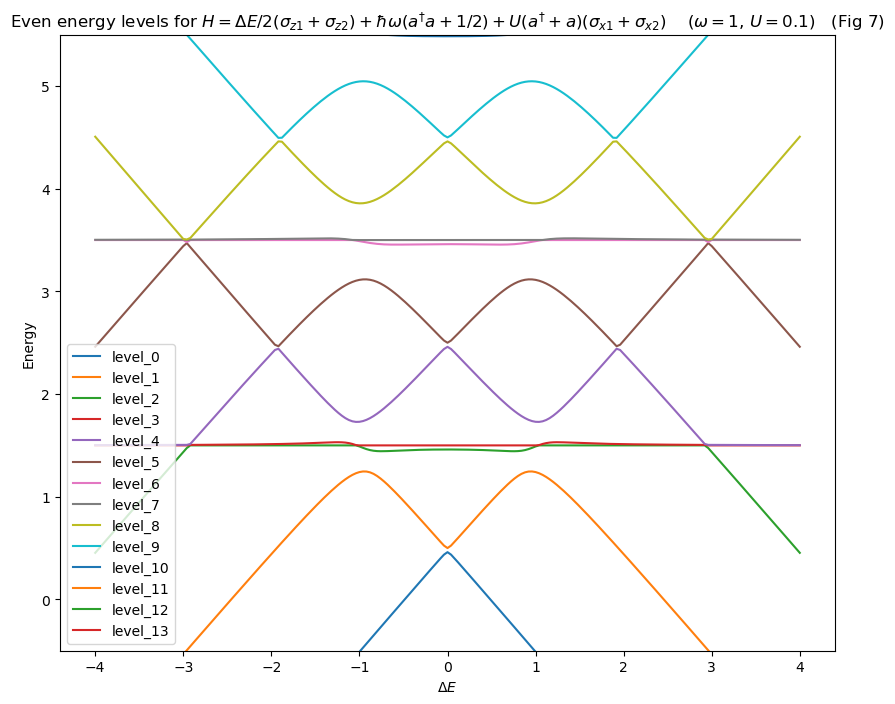

In [25]:
df_even.plot(x="$\Delta E$",ylim=[-0.5,5.5],legend=True, 
        title=f"Even energy levels for {H_latex}   ($\omega=1$, $U=0.1$)   (Fig 7)",
             figsize=(10,8));

plt.ylabel("Energy");


There are many things we can see in Fig 7:
1. Where 2 levels have come together (e.g. levels 4 and 5) we see an anti-crossing as we have come to expect from interacting levels
2. The horizontal levels of Fig 6 have split into 2 levels as we suspected. This confirms that we do indeed have 4 levels coming together at some anti-crossings, e.g. levels 1,2,3,4
3. There appear to still be genuine crossings between some levels, most strikingly seen around $\Delta E \approx 1$ between e.g. levels 2 and 3 - this indicates there might be non interacting sub-universes with each parity universe 🤔

There is a lot to explore and understand here. We'll start with two level anti-crossings, as this is the most familiar to us. We'll then look at what's happening when 4 levels are coming together.

### 5.6.1 - Two Levels

In Fig 7, levels 4 and 5 anti-cross at around $\Delta E = 2$. This anti-crossing looks like it could be linked to the $|0,+, + \rangle \rightarrow |4,-, - \rangle$ down conversion that we talked about when we explored the Hinton diagram. Let's see if we can confirm this down conversion via simulation (just as we did in [Fig 12 of tutorial 4](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/04-spin-boson-model.ipynb#4.5---Down-conversion)). 

Rather than manually zoom in on the anti-crossing to get a more precise value of $\Delta E$ to use in the simulation, we will automate the process using [`minimize_scalar`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html) from [`scipy`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html).

How will we use `minimize_scalar`? We first need to provide a function that calculates the difference in the energies of two levels.

In [26]:
def level_difference(DeltaE, omega, U, level_number):
    H = DeltaE*two_state_1 + DeltaE*two_state_2 + omega*bosons + U*interaction_1 + U*interaction_2
    evals, ekets = H.eigenstates()
    return np.abs(evals[level_number] - evals[level_number-1])

We then pass this `level_difference` function to `minimise_scalar`. The first argument of `level_difference` (i.e. `DeltaE`) will be used by `minimize_scalar` as a variable and the rest will be considered as "arguments" (i.e. fixed constants). Finally, we must specify `bounds` (i.e. min and max `DeltaE`) inside of which we expect to find the anti-crossing.

Let's give it a go using:
- `omega = 1`
- `U = 0.1`
- `level_number = 5`
- `bounds = [1.9, 2]`

In [27]:
# oemga = 1
# U = 0.1
# level_number = 5 - this will allow us to calculate level_5/4 energy difference
anti_crossing = minimize_scalar(level_difference, args=(1, 0.1, 5), method="Bounded", bounds=[1.9, 2])

In [28]:
anti_crossing

 message: Solution found.
 success: True
  status: 0
     fun: 9.469828282204773e-05
       x: 1.9328592876515285
     nit: 14
    nfev: 14

We see that the true anti-crossing occurs at $\Delta E = 1.9328593467366724$ - very precise  🤓 .

We can now use this value to create the Hamiltonian for our simulation.

> Feel free to adjust the value of  $\Delta E$ and see how sensitive the results are to the precise position of the anti-crossing.

In [29]:
H = anti_crossing.x*two_state_1 + anti_crossing.x*two_state_2 + 1*bosons + 0.1*interaction_1 + 0.1*interaction_2

We want to start the system off in the $|0,+, + \rangle$ state - this should be the first state in the state list, let's check.

In [30]:
nmm_list[0]

(0, '+', '+')

Great. We can now set up the initial state by using the `basis` function as we have done before.

In [31]:
psi0 = basis(len(nmm_list), 0)

Now we are ready to simulate

In [32]:
times = np.linspace(0.0, 100000.0, 10000)
P, psi = simulate(H, psi0, times)

We need to recreate the bra-ket labels because we are now only working with even parity states.

In [33]:
bra_labels, ket_labels = make_braket_labels(nmm_list)

Now let's plot the results using a helper function `plot_prob` that pulls together plotting code that we used in the last tutorial.

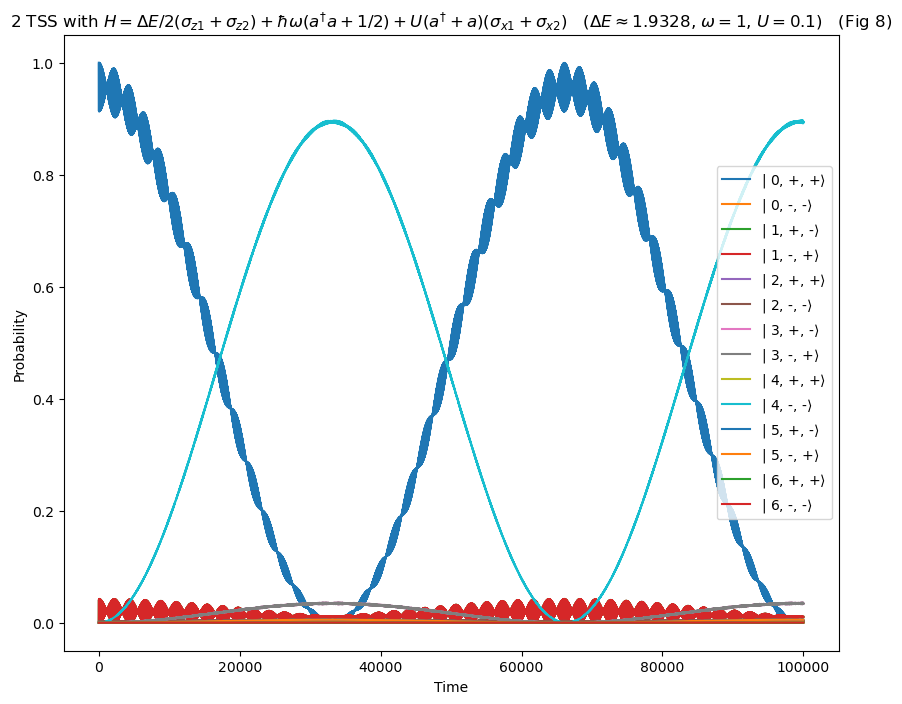

In [34]:
plot_prob(P, times, ket_labels)
plt.title(f"2 TSS with {H_latex}  ($\Delta E \\approx 1.9328$, $\omega=1$, $U=0.1$)   (Fig 8)");

Fig 8 shows exactly what we expected, namely down conversion - both TSS transition from "+" to "-" each giving of 2 bosons in the process i.e. $|0,+, + \rangle \rightarrow |4,-, - \rangle$.

### 5.6.2 - Four levels

In Fig 7, we found something unexpected for the energy levels corresponding to no overall excitation, i.e. those consisting of equal number of "+" and "-". We found that e.g. levels 2 and 3 appeared to cross each other. Considering that we are in an even parity universe, the expectation is that all levels can interact with each other and create anti-crossings in the process - so why don't levels 2 and 3 do this? It has to do with the conservation of angular momentum.

Although we don't explicitly have a description of angular momentum in our TSS, you may recall from [tutorial 2](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/02-perturbing-a-two-state-system.ipynb#Transition-probability) that our system is mathematically similar to spin $1/2$ particles which do have angular momentum. In general, the conservation of total angular momentum of a system constrains how that system can behave. We can therefore expect to find constraints in our TSS based on the conservation of what we can call `pseudo-angular momentum`.

We'll spend a lot more time on the details of pseudo-angular momentum in the next tutorial. For now, let's just try and calculate the magnitude of the total pseudo-angular momentum around $\Delta E \approx 1$ for levels 2 and 3 to see what insights we can find.

We'll need to introduce a few new operators:

- The spin operators ($S$) for a [spin 1/2 particle](https://en.wikipedia.org/wiki/Spin-%C2%BD#Observables):

$$
S_x = \frac{1}{2}\sigma_x \,\,\,\,\,\, S_y = \frac{1}{2}\sigma_y \,\,\,\,\,\, S_z = \frac{1}{2}\sigma_z
$$

- The [total angular momentum operators](https://www2.ph.ed.ac.uk/~ldeldebb/docs/QM/lect15.pdf) ($J$) for $N$ TSS:

$$J_{Nx} = \overset{N}{\underset{n=1}{\Sigma}} S_{n x} \,\,\,\,\,\, J_{Ny} = \overset{N}{\underset{n=1}{\Sigma}} S_{n y} \,\,\,\,\,\, J_{Nz} = \overset{N}{\underset{n=1}{\Sigma}} S_{n z}$$



Our Hamiltonian then looks like:

$$H =  \Delta E J_{Nz} + \hbar\omega\left(a^{\dagger}a +\frac{1}{2}\right) + U\left( a^{\dagger} + a \right)2J_{Nx}$$

In [36]:
H_latex = "$H = \Delta E J_{Nz} + \hbar\omega(a^{{\dagger}}a +1/2) + U( a^{{\dagger}} + a )2J_{Nx}$ "

To calculate the magnitude of the total pseudo-angular momentum, we'll need to use QuTiP's [`jspin`](http://qutip.org/docs/latest/apidoc/functions.html#qutip.piqs.jspin),  to generate the $J$ operators for any given number of TSS (note, you must import [`qutip.piqs`](http://qutip.org/docs/latest/apidoc/functions.html#module-qutip.piqs) to use this).

In [37]:
J = jspin(2, basis="uncoupled")

In [38]:
J[0] # J_x

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.  0.5 0.5 0. ]
 [0.5 0.  0.  0.5]
 [0.5 0.  0.  0.5]
 [0.  0.5 0.5 0. ]]

In [39]:
J[1] # J_y

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.+0.j  0.-0.5j 0.-0.5j 0.+0.j ]
 [0.+0.5j 0.+0.j  0.+0.j  0.-0.5j]
 [0.+0.5j 0.+0.j  0.+0.j  0.-0.5j]
 [0.+0.j  0.+0.5j 0.+0.5j 0.+0.j ]]

In [40]:
J[2] # J_z

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0. -1.]]

The magnitude of the total angular momentum is then represented by an operator that's the sum of the squares of the individual component operators (see [spinors](https://en.wikipedia.org/wiki/Spinors_in_three_dimensions) for a deeper discussion of this).

In [41]:
J2 = J[0]*J[0] + J[1]*J[1] + J[2]*J[2]

These new operators will need to be tensorised just like our other operators. We'll adapt our `make_operators` function for this. Note that we've also needed to adapt the parity operator to work with $J_z$.

In [42]:
def make_operators(max_bosons, parity=0):
    
    a     = tensor(destroy(max_bosons+1), qeye(2),qeye(2))                 # tensorised boson destruction operator
    J     = jspin(2, basis="uncoupled")
    Jx    = tensor(qeye(max_bosons+1), J[0])                               # tensorised Jx operator
    Jz    = tensor(qeye(max_bosons+1), J[2])                               # tensorised Jx operator
    J2    = tensor(qeye(max_bosons+1), J[0]*J[0] + J[1]*J[1] + J[2]*J[2])  # tensorised J^2 operator

    two_state     = Jz                                 # two state system energy operator   Jz
    bosons        = (a.dag()*a+0.5)                    # boson energy operator              𝑎†𝑎+1/2
    number        = a.dag()*a                          # boson number operator              𝑎†𝑎
    interaction   = 2*(a.dag() + a) * Jx               # interaction energy operator        2(𝑎†+𝑎)Jz  
    
    P = -(1j*np.pi*(number + Jz)).expm()               # parity operator 
    
    # map from QuTiP number states to |n,±, ±> states
    possible_ns = range(0, max_bosons+1)
    possible_ms = ["+","-"]
    nmm_list = [(n,m1,m2) for (n,m1,m2) in product(possible_ns, possible_ms, possible_ms)]
    
    # only do parity extraction if a valid parity is being used
    if (parity==1) | (parity==-1):
        p               = np.where(P.diag()==parity)[0]
        
        two_state       = two_state.extract_states(p)
        bosons          = bosons.extract_states(p)
        number          = number.extract_states(p)
        interaction     = interaction.extract_states(p)
        J2              = J2.extract_states(p)  
        nmm_list        = [nmm_list[i] for i in p]
  
    
    return two_state, bosons, interaction, number, nmm_list, J2

Let's now create a zoomed in version of the Fig 6 energy level diagram (where interaction is turned off  $U=0$) around the area of interest for levels 2 and 3.

In [43]:
two_state, bosons, interaction, number, nmm_list, J2 = make_operators(max_bosons=6, parity=1)

In [44]:
df_even = make_df_for_energy_scan("$\Delta E$", 0.7, 1.3, 201, two_state.shape[0])

for i, row in df_even.iterrows():
    H =  row["$\Delta E$"]*two_state + 1*bosons
    evals, ekets = H.eigenstates()
    df_even.iloc[i,1:] = evals 

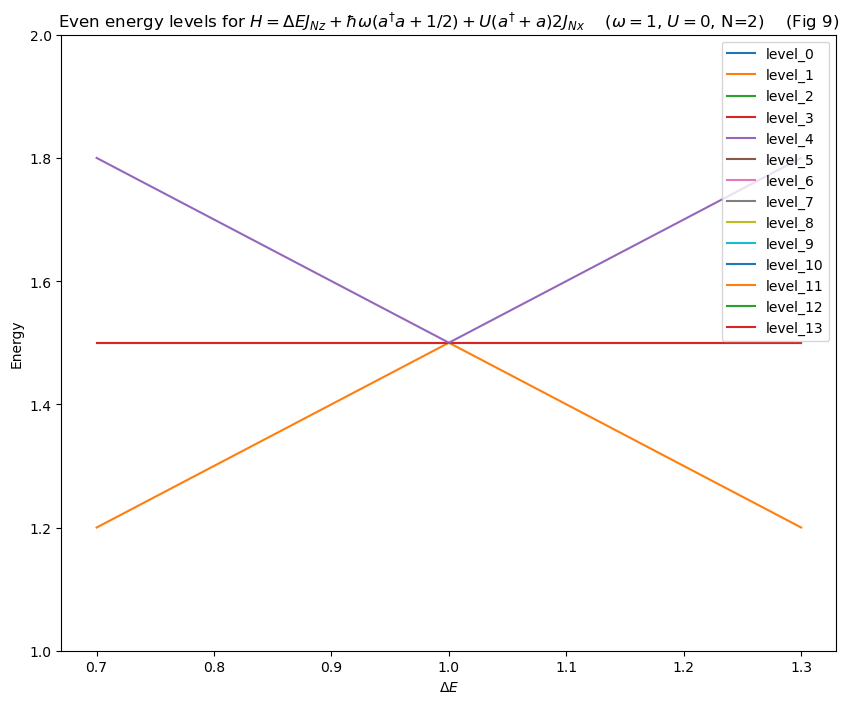

In [46]:
df_even.plot(x="$\Delta E$",ylim=[1,2],legend=True, 
        title=f"Even energy levels for {H_latex}   ($\omega=1$, $U=0$, N=2)    (Fig 9)",
             figsize=(10,8));

plt.ylabel("Energy");

Let's now look at the 4 energy levels visible in Fig 9 and calculate the square total pseudo-angular momentum. Specifically, we're going to calculate the expectation value of $J^2$ for each energy level at each value of $\Delta E$. For this, we'll use QuTip's [`expect`](https://qutip.org/docs/latest/apidoc/functions.html#module-qutip.expect) function.

In [47]:
df_J_even = make_df_for_energy_scan("$\Delta E$", 0.7, 1.3, 201, two_state.shape[0])

for i, row in df_J_even.iterrows():
    H =  row["$\Delta E$"]*two_state + 1*bosons + 0.1*interaction
    evals, ekets = H.eigenstates()
    df_J_even.iloc[i,1:] = expect(J2,ekets)  # The expected square total angular momentum for each energy level
    
df_J_even[["$\Delta E$", "level_1", "level_2", "level_3", "level_4"]].head()

,$\Delta E$,level_1,level_2,level_3,level_4
0,0.700,2.0,2.0,4.930381e-32,2.0
1,0.703,2.0,2.0,1.972152e-29,2.0
2,0.706,2.0,2.0,9.860761e-32,2.0
3,0.709,2.0,2.0,1.696051e-29,2.0
4,0.712,2.0,2.0,5.916457e-31,2.0


We can see that the horizontal level 3 has $<J^2> = 0$ (tiny non-zero values are due to numerical limitations) whereas the others have $<J^2> = 2$. Because pseudo-angular momentum is conserved, level 3 cannot influece the others, even when the energies are the same. For example, at $\Delta E = 1$ when all the levels converge, frequency "beating" will only occur between levels 1, 2 and 4 where the pseudo-angular momentum is the same. Level spltting accompanies that beating, as we've seen several times during these tutorials and we see in Fig 7 when  $U \neq 0$. Level 3 is however excluded from the beating and that's why its energy remains the same whether or not there is any ineraction with the boson field.

So, when we see 4 levels coming together, in practical terms it's 3 + 1. Thinking about 3 interacting levels is more complicated than the 2 we've been used to. We'll not dig into that in this tutorial because what's more interesting is to look at the novel feature we found in the Hinton diagram - the suggestion of something we termed excitation transfer.

## 5.7 - Excitation transfer

The Hinton diagram in Fig 3 hinted at an indirect transition of the form $|1,+, - \rangle \rightarrow |1,-, + \rangle$. This transition appears to be mediated by several states. We highlighted $ |0,+, + \rangle$ in particular, but there are others too. Let's run a simulation using $\Delta E = \omega$ with initial condition $|1,+, - \rangle$ and see what other states are involved.

First, let's find which number state $|1,+, - \rangle$ corresponds to

In [48]:
nmm_list

[(0, '+', '+'),
 (0, '-', '-'),
 (1, '+', '-'),
 (1, '-', '+'),
 (2, '+', '+'),
 (2, '-', '-'),
 (3, '+', '-'),
 (3, '-', '+'),
 (4, '+', '+'),
 (4, '-', '-'),
 (5, '+', '-'),
 (5, '-', '+'),
 (6, '+', '+'),
 (6, '-', '-')]

We need state number 2.

In [49]:
nmm_list[2]

(1, '+', '-')

For this simulation, we'll reduce the interaction strength.

In [50]:
H = 1*two_state + 1*bosons + 0.01*interaction

In [51]:
psi0 = basis(len(nmm_list), 2)
times = np.linspace(0.0, 1000.0, 10000)
P, psi = simulate(H, psi0, times)

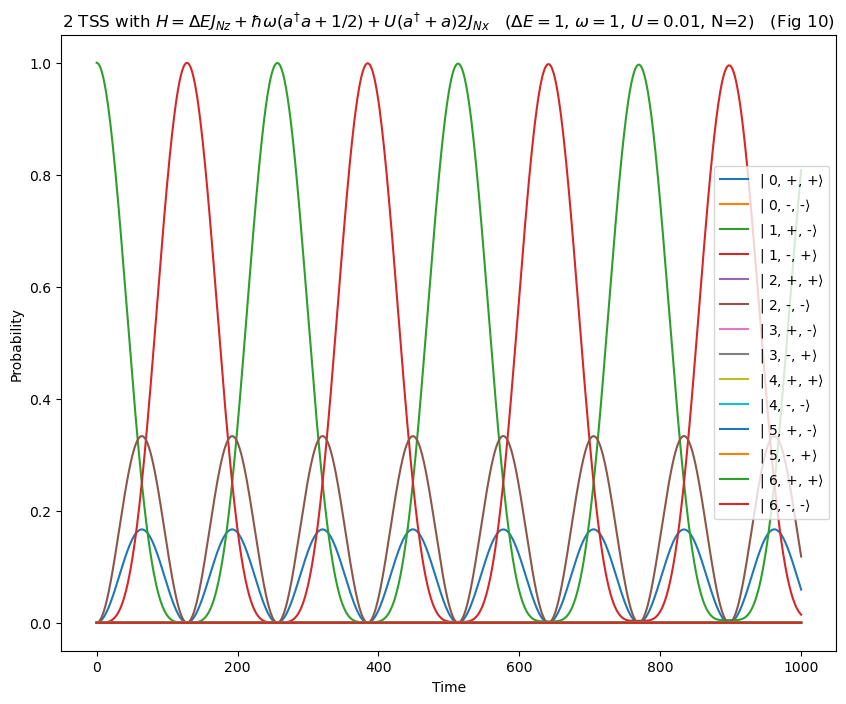

In [53]:
bra_labels, ket_labels = make_braket_labels(nmm_list)
plot_prob(P ,times, ket_labels)
plt.title(f"2 TSS with {H_latex}  ($\Delta E = 1$, $\omega=1$, $U=0.01$, N=2)   (Fig 10)");

Success, we do indeed see the system move from $|1,+, - \rangle \rightarrow |1,-, + \rangle$ as we predicted.

We can interpret the excitation transfer in Fig 10 in the following ways:
- 1
  - TSS_1 (the one initially in the "+" state) transitions to the lower "-" state, releasing energy
  - The energy goes into emitting an extra boson, taking the field from 1 to 2 bosons
  - TSS_2 (the one initially in the "-" state) absorbs a boson taking it to the "+" state and the field from 2 to 1 boson
  
  
- 2
  - TSS_2 (the one initially in the "-" state) absorbs energy and transitions to upper "+" state
  - This absorbed energy comes from the boson field, taking the number of bosons from 1 to 0
  - TSS_1 (the one initially in "+" state) emits a boson taking it to the "-" state and the field from 0 to 1 boson
  
 
This mechanics as described above leads us to a mental model of excitation transfer as simply the exchange of bosons between one TSS and another - each boson carrying the entire transition energy of the TSS ($\Delta E$). This is indeed one way that excitation transfer can occur, but it's not the only way. The entire transition energy $\Delta E$ can be conferred from one TSS to another without a single boson being emitted\absorbed 🤯 . 

Skeptical...you should be. Let's see it in action and then try and understand it.

### Non radiative excitation transfer

We're now going to perform the same simulation as above but this time we will set $\Delta E = 2.5\omega$. It is now impossible for an integer number of bosons to transmit the transition energy $\Delta E$ from TSS_1 to TSS_2.

In [54]:
H = 2.5*two_state + 1*bosons + 0.01*interaction

We'll again start the system in the state $|1,+,- \rangle$.

In [55]:
psi0 = basis(len(nmm_list), 2)
times = np.linspace(0.0, 100000.0, 10000)
P, psi = simulate(H, psi0, times)

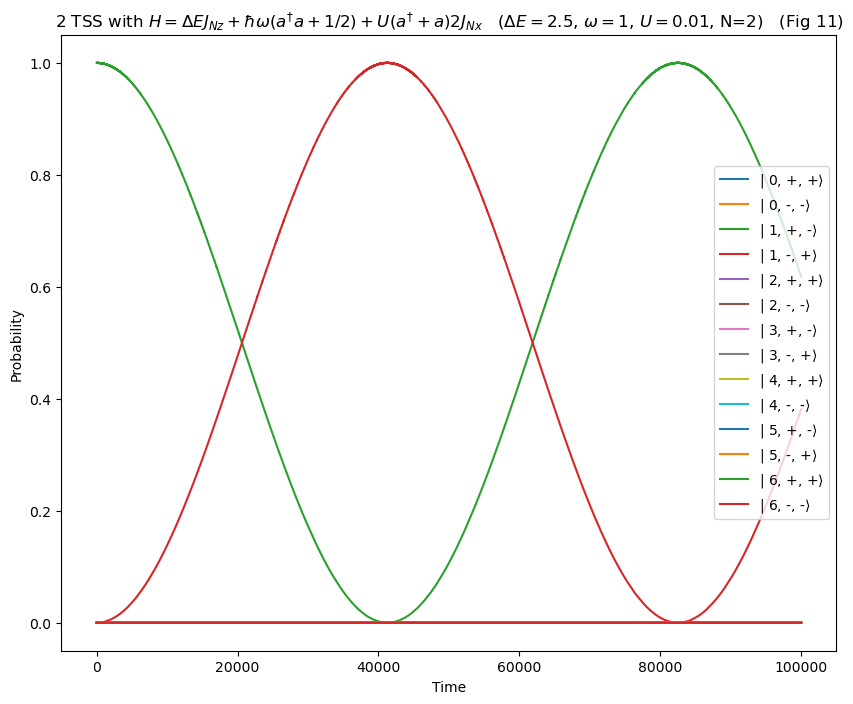

In [56]:
plot_prob(P ,times, ket_labels)
plt.title(f"2 TSS with {H_latex}  ($\Delta E = 2.5$, $\omega=1$, $U=0.01$, N=2)   (Fig 11)");

Fig 11 shows us that excitation can be transfered from one TSS_1 to TSS_2 without bosons having any significant chance of being emitted/absorbed.

How is it possible to transfer energy quantum mechanically without radiation of bosons? We can't do the topic justice in a single notebook, but we can point to similar phenomenon in classical physics. Specifically, the [near field](https://en.wikipedia.org/wiki/Near_and_far_field) is the non-radiative part of the electromagnetic field that can be used to e.g. [transfer power wirelessly](https://en.wikipedia.org/wiki/Wireless_power_transfer) from one device to another without radiating the power in all directions (as we would associate with something like radio transmitter). 

In the context of quantum mechanics, in systems more physically realistic than what we describe in this notebook, such non radiative transfers of energy are made by something called virtual bosons. In general, [virtual particles](https://profmattstrassler.com/articles-and-posts/particle-physics-basics/virtual-particles-what-are-they) are quite a complicated business so we will return to them in a later tutorial. We can however say that their application to the mature research area of [Resonance Energy Transfer](https://www.frontiersin.org/articles/10.3389/fphy.2019.00100/full) (used to explain certain dynamics of photosynthesis in plants among other things) is common place.

This is a most striking observation, but let's not get too carried away with the surprise of it all. Let's see if we can understand it in terms of concepts we already understand.

From our experience over the past few tutorials, when we see such clean oscillations like in Fig 11, it suggests that we've got some kind of frequency ["beating"](https://en.wikipedia.org/wiki/Beat_%28acoustics%29) going on. Let's see this by transforming our initial state $|1,+, - \rangle $ into the basis corresponding to the stationary states (those with constant energy).

In [57]:
evals, ekets = H.eigenstates()
psi0_in_H_basis = psi0.transform(ekets)

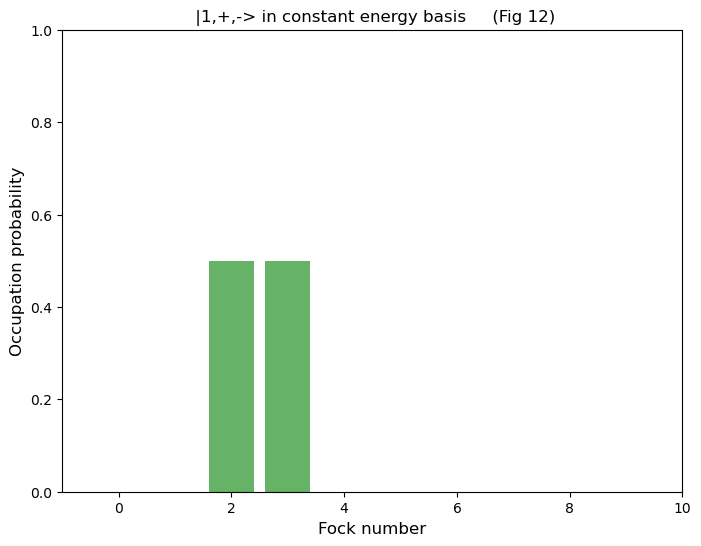

In [58]:
plot_fock_distribution(psi0_in_H_basis, title=f" |1,+,-> in constant energy basis     (Fig 12)")
plt.xlim(-1,10);

Fig 12 shows us that $|1,+, - \rangle $ is actually a mixture of energy levels 2 and 3 (a similar picture could be made for $|1,-, + \rangle $). Just as we've seen in previous tutorials, when we have an initial state that's a mixture of two energy levels, we get Rabi oscillations.

We can calculate the oscillation period based on this energy difference between the levels.

In [59]:
2*np.pi / (evals[3] - evals[2])

82511.70805176851

This time matches up with the excitation transfer period we observed in Fig 11.

Although this non-radiative excitation transfer might seem counter intuitive, we see that we can begin to understand it in terms of concepts that we introduced all the way back at the start of our quantum journey. This should give you confidence that with bit more time, we will obtain the quantum mastery that we seek 🧙‍ .

## Next up

As always, this is only the beginning. There are so many more questions to ask, details to dig into, avenues to explore...
- What happens when we add more TSS?
- Can we have excitation transfer when the TSS don't have exactly the same $\Delta E$? 
- Does excitation transfer still work with a spectrum of modes?
- ...

Until next time 👋